# Anchor boxes

In [2]:
import scipy.io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pandas as pd
from sklearn.cluster import KMeans
import itertools
from scipy.stats import norm

## Data

We first inspect the data so we can define the anchor boxes:

In [3]:
imgs_path = '/home/marko/data/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/'
anno_path = '/home/marko/data/citypersons/'

In [4]:
def get_annotations(anno_path):
    ''' Prepares data - only train data for now, by
    transforming annotations from .mat format to a dictionary.
    '''
    
    anno_train = scipy.io.loadmat(anno_path + 'anno_train.mat')
    anno_train = anno_train['anno_train_aligned']

    d = {}
    for i in range(anno_train[0].shape[0]):
        # extract data from the annotations matrix
        city_name = anno_train[0, i][0][0][0][0]
        img_name = anno_train[0, i][0][0][1][0]

        bboxes = []
        for bb in anno_train[0, i][0][0][2]:
            ## format is: [class_label, x1,y1,w,h, instance_id, x1_vis, y1_vis, w_vis, h_vis]
            if bb[0] > 0: 
                #class_label =1: pedestrians
                #class_label =2: riders (e.g. cyclist)
                #class_label =3: sitting persons
                #class_label =4: other persons with unusual postures
                #class_label =5: group of people                
                bboxes.append(bb[1:5]) # bbox = [x, y, w, h]

        d[img_name] = bboxes
    
    return d

In [5]:
anno_dict = get_annotations(anno_path)
imgs = list(anno_dict.keys())
print('There are %d images.' % len(imgs))

There are 2975 images.


In [6]:
## extract only images with people inside
imgs_person = []
for img in imgs:
    bboxes = anno_dict[img]
    if len(bboxes) > 1:
        imgs_person.append(img)
        
print('There are %d images with people.' % (len(imgs_person)))

There are 2117 images with people.


In [7]:
## count the number of ground truth bounding boxes
n_bboxes = 0
for img_name in imgs_person:
    n_bboxes += len(anno_dict[img_name])

print('There are %d bounding boxes.' %(n_bboxes))

There are 20619 bounding boxes.


In [8]:
print('There are %.2f people per image on average.' % (n_bboxes/len(imgs_person)))

There are 9.74 people per image on average.


In [9]:
## extract all bounding boxes
n = len(imgs_person)

## include the centers and areas
all_bboxes = np.zeros((n_bboxes, 4 + 3))

i = 0
for img_name in imgs_person:
    bboxes = anno_dict[img_name]
    for bbox in bboxes:
        x, y, w, h = bbox
        
        cx, cy = x + w/2, y + h/2        
        area = int(w) * int(h)

        all_bboxes[i] = np.array(
            [x, y, w, h, cx, cy, area])
        i += 1
        
all_bboxes[:5]        

array([[ 892. ,  445. ,   21. ,   53. ,  902.5,  471.5, 1113. ],
       [ 901. ,  443. ,   34. ,   55. ,  918. ,  470.5, 1870. ],
       [1844. ,  436. ,   44. ,  106. , 1866. ,  489. , 4664. ],
       [1692. ,  417. ,   26. ,   64. , 1705. ,  449. , 1664. ],
       [1722. ,  441. ,   13. ,   31. , 1728.5,  456.5,  403. ]])

In [10]:
all_bboxes_df = pd.DataFrame(all_bboxes, columns = ['x', 'y', 'w', 'h', 'cx', 'cy', 'area'])
all_bboxes_df.head()

,x,y,w,h,cx,cy,area
0,892.0,445.0,21.0,53.0,902.5,471.5,1113.0
1,901.0,443.0,34.0,55.0,918.0,470.5,1870.0
2,1844.0,436.0,44.0,106.0,1866.0,489.0,4664.0
3,1692.0,417.0,26.0,64.0,1705.0,449.0,1664.0
4,1722.0,441.0,13.0,31.0,1728.5,456.5,403.0


In [11]:
all_bboxes_df.tail()

,x,y,w,h,cx,cy,area
20614,162.0,405.0,70.0,169.0,197.0,489.5,11830.0
20615,682.0,352.0,86.0,210.0,725.0,457.0,18060.0
20616,772.0,461.0,22.0,53.0,783.0,487.5,1166.0
20617,762.0,465.0,20.0,49.0,772.0,489.5,980.0
20618,1694.0,414.0,54.0,131.0,1721.0,479.5,7074.0


### Small bounding boxes

In [12]:
## what is the smallest bounding box?
all_bboxes_df['area'].min()

1.0

In [13]:
np.min(all_bboxes[:,6])

1.0

In [14]:
## double-check
min_area = 1e4
for img_name in imgs_person:
    bboxes = anno_dict[img_name]
    for bbox in bboxes:
        bbox = bbox.astype(np.uint16)
        x, y, w, h = bbox
        area = int(w) * int(h)
        if area < min_area:
            min_area = area
min_area

1

1 pixel size bounding box?!

In [15]:
all_bboxes_df = all_bboxes_df.sort_values(by=['area'])
all_bboxes_df.head(5)

,x,y,w,h,cx,cy,area
9603,827.0,363.0,1.0,1.0,827.5,363.5,1.0
14406,792.0,442.0,1.0,1.0,792.5,442.5,1.0
17464,217.0,489.0,1.0,1.0,217.5,489.5,1.0
5296,1380.0,440.0,1.0,1.0,1380.5,440.5,1.0
7207,1328.0,370.0,1.0,1.0,1328.5,370.5,1.0


In [16]:
## let's plot the first image with w = h = 1
min_i = 9603
min_j = 0
i = 0
for j in range(len(imgs_person)):
    img_name = imgs_person[j]
    bboxes = anno_dict[img_name]
    for bbox in bboxes:
        if i == min_i:
            min_j = j
        i += 1
min_j

950

[827 363   1   1]


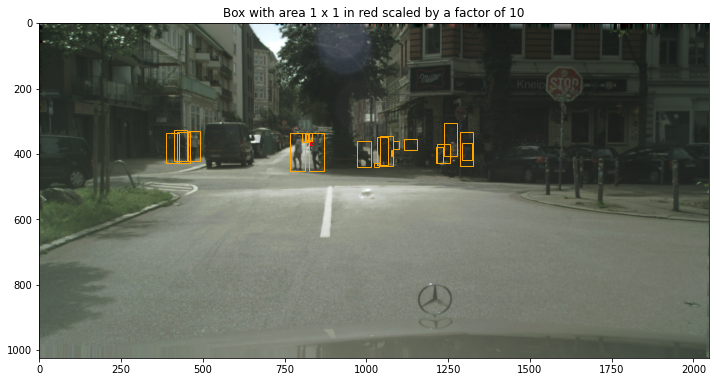

In [17]:
img_name = imgs_person[min_j]
city_name = img_name.split('_')[0]
img_path = imgs_path + city_name + '/' + img_name
img = Image.open(img_path)
bboxes = anno_dict[img_name]

plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img)
for bbox in bboxes:
    x, y, w, h = bbox
    if w == 1 and h == 1:
        print(bbox)
        title = 'Box with area %d x %d in red scaled by a factor of 10' %(w, h)
        color = 'red'
        rect = patches.Rectangle(
            (x, y), w*10, h*10,
            linewidth=1, edgecolor=color, facecolor='none')        
        ax.add_patch(rect)        
    else:
        color = 'orange'
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=1, edgecolor=color, facecolor='none')        
        ax.add_patch(rect)        

plt.title(title)
plt.savefig('../figures/small-bbox-example.png', 
            dpi=300, facecolor='white', transparent=True)
plt.show()

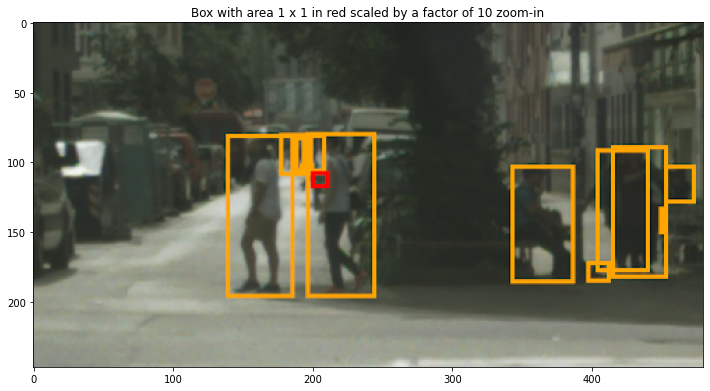

In [18]:
## let's zoom in on this 1x1 bbox region
img = Image.open('../figures/small-bbox-example-zoom-in.png')

plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img)    

plt.title(title + ' zoom-in')
plt.show()

This are most likely artefacts of image annotation tool or whatever they used when creating this dataset. We will remove too small bounding boxes that don't make sense:

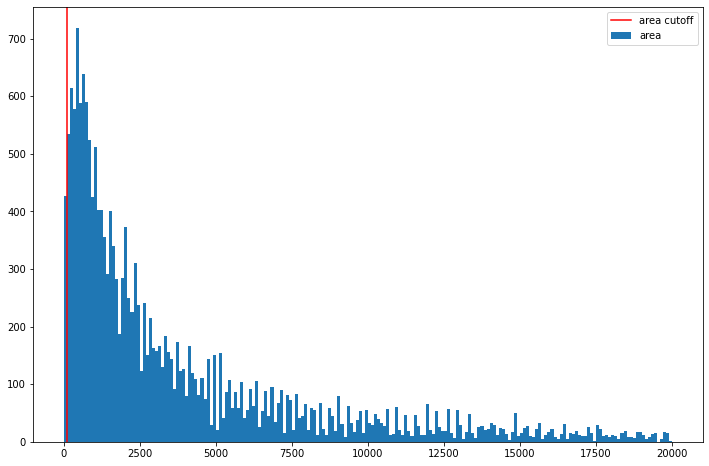

In [19]:
areas = np.array(all_bboxes_df['area'])
cutoff = 100
plt.hist(areas, bins=200, range=(0, 2*1e4), label='area')
plt.axvline(x=cutoff, color='r', label='area cutoff')
plt.legend()
plt.show()

In [20]:
## fix the dictionary
anno_dict2 = {}
for img in list(anno_dict.keys()):
    bboxes = anno_dict[img]

    bboxes2 = []
    for bbox in bboxes:
        if np.prod(bbox[2:]) > cutoff:
            bboxes2.append(bbox)
    
    anno_dict2[img] = bboxes2
assert len(anno_dict) == len(anno_dict2), 'Problems'

In [21]:
all_bboxes_df.head()

,x,y,w,h,cx,cy,area
9603,827.0,363.0,1.0,1.0,827.5,363.5,1.0
14406,792.0,442.0,1.0,1.0,792.5,442.5,1.0
17464,217.0,489.0,1.0,1.0,217.5,489.5,1.0
5296,1380.0,440.0,1.0,1.0,1380.5,440.5,1.0
7207,1328.0,370.0,1.0,1.0,1328.5,370.5,1.0


In [22]:
filtered_bboxes_df = all_bboxes_df[all_bboxes_df['area'] > cutoff]

In [23]:
print('We dropped %d bboxes with areas smaller than %d.' % 
      (all_bboxes_df.shape[0] - filtered_bboxes_df.shape[0], cutoff))

We dropped 429 bboxes with areas smaller than 100.


In [24]:
## keep only filtered dict and filtered df
anno_dict = anno_dict2
df = filtered_bboxes_df
all_bboxes = df[['x', 'y', 'w', 'h']].to_numpy()
assert df.shape[0] == all_bboxes.shape[0], 'Problem'

In [25]:
## what is the smallest bounding box now?
df['area'].min()

102.0

TODO: we could check the image with the smallest bbox to see if there are any more problems.

## Analysis of bounding boxes

To define the anchor boxes we need to choose:

* Aspect ratios of the boxes
* Areas of the boxes
* Anchor points, i.e. centers of the boxes

### Aspect ratios and areas

To choose the aspect ratios and areas, we plot widths and heights of ground truth bounding boxes in our train set:

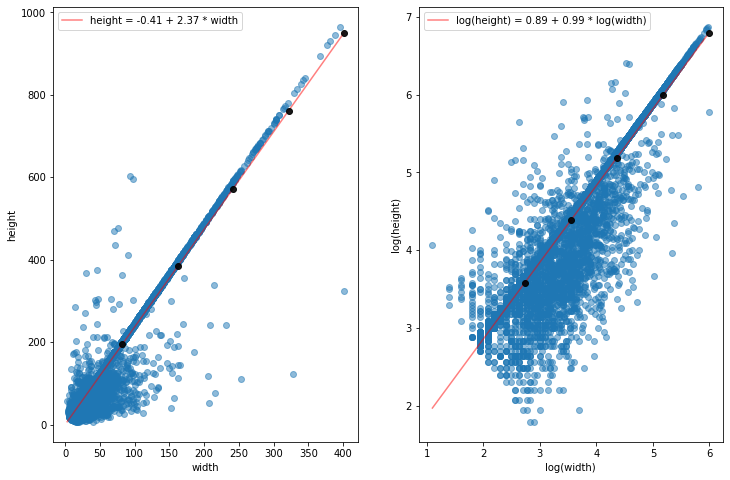

In [26]:
w = np.array(df['w'])
h = np.array(df['h'])

plt.rcParams['figure.figsize'] = [12, 8]
fig, axs = plt.subplots(1, 2)

## plot widths and heights
axs[0].plot(w, h, 'o', alpha=0.5)

## plot a regression line
m, b = np.polyfit(w, h, 1)
x = np.linspace(np.min(w), np.max(w), 100)
label = 'height = %.2f + %.2f * width' % (b, m)
axs[0].plot(x, m*x + b, 'r-', label=label, alpha=.5)

## plot some points on the regression line

K = 5 # number of points TODO: decide on K = 1, 2, 3...

ws = np.linspace(np.min(w), np.max(w), K+1)[1:]
hs = m * ws + b
axs[0].plot(ws, hs, 'ko', alpha=0.9)

axs[0].set_xlabel('width')
axs[0].set_ylabel('height')
axs[0].legend(loc="upper left")

### let's do the same in log-log space
## plot widths and heights
w = np.log(w)
h = np.log(h)
axs[1].plot(w, h, 'o', alpha=0.5)

## plot a regression line
m, b = np.polyfit(w, h, 1)
x = np.linspace(np.min(w), np.max(w), 100)
label = 'log(height) = %.2f + %.2f * log(width)' % (b, m)
axs[1].plot(x, m*x + b, 'r-', label=label, alpha=.5)

## plot some points on the regression line
ws = np.linspace(np.min(w), np.max(w), K+2)[2:]
hs = m * ws + b
axs[1].plot(ws, hs, 'ko', alpha=0.9)

axs[1].set_xlabel('log(width)')
axs[1].set_ylabel('log(height)')
axs[1].legend(loc="upper left")

plt.show()

Let's fix the aspect rate of anchor boxes to the slope of regression line and choose 10 different sizes:

In [27]:
def get_whs(df, K=5):
    w = np.array(df['w'])
    h = np.array(df['h'])
    m, b = np.polyfit(w, h, 1)
    ws = np.linspace(np.min(w), np.max(w), K+1)[1:]
    hs = m * ws + b
    whs = np.vstack((ws, hs)).transpose()
    
    return whs

In [28]:
get_whs(df)

array([[ 82.6       , 195.26457145],
       [162.2       , 383.83381848],
       [241.8       , 572.4030655 ],
       [321.4       , 760.97231252],
       [401.        , 949.54155954]])

### Anchor points

In [29]:
img_name = imgs_person[0]
city_name = img_name.split('_')[0]
img_path = imgs_path + city_name + '/' + img_name
img = Image.open(img_path)
H, W = np.array(img).shape[:2]

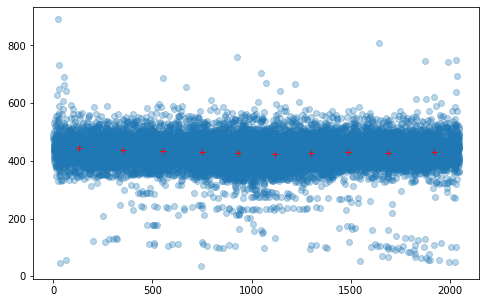

In [30]:
plt.rcParams['figure.figsize'] = [8, 5]

## plot bbox centers 
plt.plot(np.array(df['cx']), np.array(df['cy']), 'o', alpha=.3)

## add 10 cetroids from k-means
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters).fit(df[['cx', 'cy']])
centroids = kmeans.cluster_centers_
plt.plot(centroids[:, 0], centroids[:, 1], 'r+')

img_np = np.array(img)
H, W = img_np.shape[:2]

plt.show()

In [31]:
xys = centroids
xys

array([[ 748.08299955,  432.15932354],
       [1487.61657303,  430.53487828],
       [ 353.47404949,  437.75105613],
       [1116.40262779,  425.13228942],
       [1920.07836735,  431.62081633],
       [ 127.20362319,  443.01449275],
       [1687.91804281,  428.42079511],
       [1297.7730038 ,  427.56939163],
       [ 929.6205036 ,  427.22821743],
       [ 552.35525   ,  434.79775   ]])

### Anchor boxes

In [32]:
def cart_prod(x, y):
    x = list(x)
    y = list(y)

    prod = []
    for p in itertools.product(x, y):
        prod.append([p[0][0], p[0][1], p[1][0], p[1][1]])
    
    return np.array(prod)

In [33]:
whs = get_whs(df, 8)
regions = cart_prod(xys, whs)
assert whs.shape[0] * xys.shape[0] == len(regions), 'Wrong'

In [34]:
## change the regions format to [x,y,w,h]
regions_xy = []
for region in regions:
    cx, cy, w, h = region
    x, y = cx - w/2, cy - h/2
    regions_xy.append([x,y,w,h])
regions = regions_xy # keep only regions in [x,y,w,h] format    

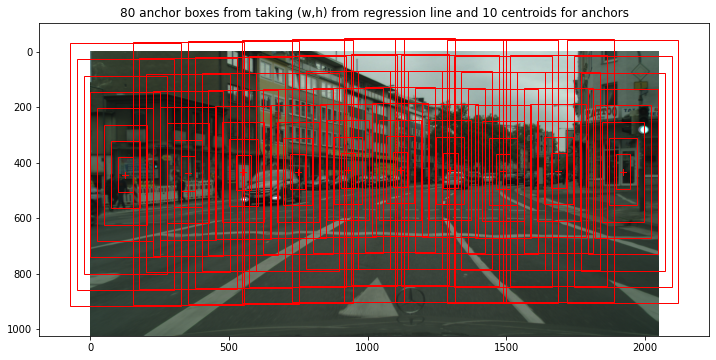

In [35]:
i = 1
img_name = imgs_person[i]
city_name = img_name.split('_')[0]
img_path = imgs_path + city_name + '/' + img_name
img = Image.open(img_path)
bboxes = anno_dict[img_name]

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
ax.imshow(img);

for bbox in regions:
    x, y, w, h = bbox
    cx, cy = x + w/2, y + h/2
    
    plt.plot(cx, cy, 'r+')
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title('%d anchor boxes from taking (w,h) from regression line and 10 centroids for anchors' % (len(regions)))
plt.show()

In [36]:
## check the cover

In [37]:
def get_IoU(bbox1, bbox2):
    x11, y11, w1, h1 = bbox1
    x21, y21, w2, h2 = bbox2
    
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2
    
    x1 = max(x11, x21)
    x2 = min(x12, x22)
    
    y1 = max(y11, y21)
    y2 = min(y12, y22)
    
    width = x2 - x1
    height = y2 - y1
    
    if width < 0 or height < 0:
        return 0.0
    else:
        overlap = width * height
        
        area_a = (x12 - x11) * (y12 - y11)
        area_b = (x22 - x21) * (y22 - y21)
        
        combined = area_a + area_b - overlap
        return overlap / (combined + 1e-5)

In [38]:
## calculate IoUs between GT BBoxes and proposed regions
max_ious = []
for bbox in all_bboxes:
    ious = [get_IoU(regions[i], bbox) for i in range(len(regions))]
    max_ious.append(np.max(ious))

In [205]:
print('Average IoU(bbox, region) for (%d x %d) = (#anchors x #scales) anchor boxes is %.2f.' 
      % (xys.shape[0], whs.shape[0], np.mean(max_ious)))

Average IoU(bbox, region) for (200 x 2) = (#anchors x #scales) anchor boxes is 0.14.


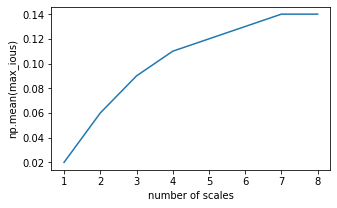

In [39]:
scales = np.arange(1,9)
ious = [0.02, 0.06, 0.09, 0.11, 0.12, 0.13, 0.14, 0.14]

plt.rcParams['figure.figsize'] = [5, 3]
plt.plot(scales, ious)
plt.xlabel('number of scales')
plt.ylabel('np.mean(max_ious)')
plt.show()

## Increasing the number of anchors

First, increase first the number of anchor boxes in vertical direction by selecting y coordinates of anchors from the parts of distribution of y coordinates of ground truth bounding boxes with highest density:

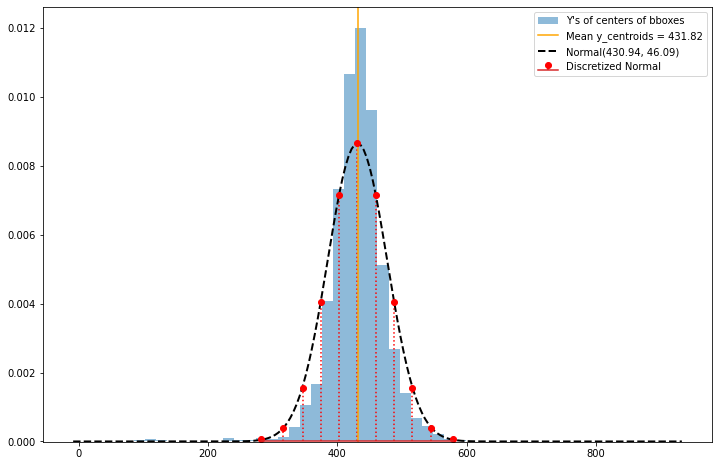

In [40]:
plt.rcParams['figure.figsize'] = [12, 8]

## let's plot centers of ground truth bounding boxes (cys)
cys = np.array(df['cy'])
plt.hist(cys, bins=50, density=True, alpha=0.5,
         label='Y\'s of centers of bboxes')

## add mean y from centroids
ys = xys[:, 1]
plt.axvline(x=np.mean(ys), color='orange', label='Mean y_centroids = %.2f' % (np.mean(ys)))

## add normal distribution fit to cys
mu, std = np.mean(cys), np.std(cys)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label='Normal(%.2f, %.2f)' %(mu, std))

## add a lollipop plot of discretizted discretized normal distribution
# from R
yks_std = np.array([-3.2224205, -2.4823550, -1.8403215, -1.2204836, -0.6086431, 0,
                     0.6086431,  1.2204836,  1.8403215,  2.4823550,  3.2224205])
pks = np.array([0.001669653, 0.011208502, 0.044191711, 0.115485500, 0.204154759, 
                0.246579754, 0.204154759, 0.115485500, 0.044191711, 0.011208502, 
                0.001669653])
yks = std * yks_std + mu

markerline, stemlines, baseline = plt.stem(
    yks, pks/28.5, markerfmt='ro', label='Discretized Normal')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')

ymin, ymax = plt.ylim()
plt.ylim(-1e-5, ymax)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0, 1, 3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.show()

In [41]:
def get_ys(K):
    yks = np. array([282.41711777, 316.52672662, 346.11804192, 374.68636231,
                     402.88608265, 430.93843487, 458.99078709, 487.19050742,
                     515.75882782, 545.35014312, 579.45975197])
    if K==1:
        return yks[5]
    if K > 5 or K < 1:
        return yks
    else:
        return yks[0:-1:(7-K)]

Next, increase the number of anchors in horizontal direction. The distribution of x coordinates of ground truth boxes is more flat, so let's just make a finer grid:

In [42]:
print('Image is %d x %d pixels and we are using %d cutoff.' 
      % (W, H, cutoff))

Image is 2048 x 1024 pixels and we are using 100 cutoff.


In [43]:
def get_xs(K):
    ## from (cutoff) pixels (our "resolution") to (W - cuttof)
    return np.linspace(cutoff/(K/10), W - cutoff/(K/10), K) 

### Anchors

We have 50 x 5 = 250 anchors


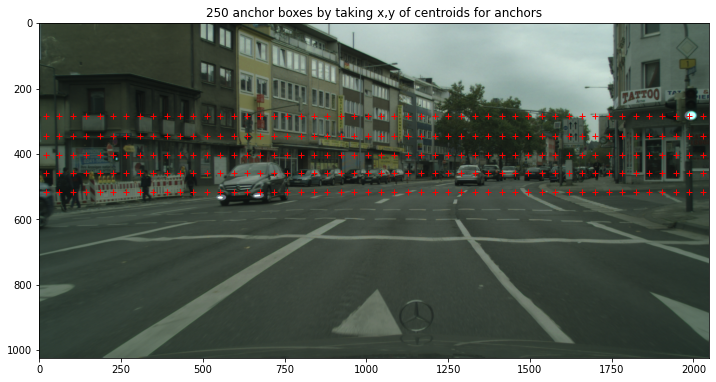

In [47]:
K1, K2 = 50, 5
xs = get_xs(K1)
ys = get_ys(K2)

xys = np.array([[x, y] for x in xs for y in ys])
print('We have %d x %d = %d anchors' 
      % (len(xs), len(ys), xys.shape[0]))

i = 1
img_name = imgs_person[i]
city_name = img_name.split('_')[0]
img_path = imgs_path + city_name + '/' + img_name
img = Image.open(img_path)
bboxes = anno_dict[img_name]

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
ax.imshow(img)

for xy in xys:
    plt.plot(xy[0], xy[1], 'r+')

plt.title('%d anchor boxes by taking x,y of centroids for anchors' % (xys.shape[0]))
plt.show()

### Anchor boxes 

In [48]:
## combine again with widths and heights
K3 = 6
xs = get_xs(K1)
ys = get_ys(K2)
whs = get_whs(df, K3)
regions = cart_prod(xys, whs)

In [49]:
## change the regions format to [x,y,w,h]
regions_xy = []
for region in regions:
    cx, cy, w, h = region
    x, y = cx - w/2, cy - h/2
    regions_xy.append([x,y,w,h])
regions = regions_xy # keep only regions in [x,y,w,h] format   

In [50]:
print('We now have %d anchor boxes.' % (len(regions)))

We now have 1500 anchor boxes.


In [554]:
## calculate IoUs between GT BBoxes and proposed regions
max_ious = []
for bbox in all_bboxes:
    ious = [get_IoU(regions[i], bbox) for i in range(len(regions))]
    max_ious.append(np.max(ious))

In [555]:
print('Average IoU(bbox, region) = %.2f' % (np.mean(max_ious)))

Average IoU(bbox, region) = 0.30
